# Registration and tracking: optical flow

In [2]:
from skimage import io

# Read image from disk.
astack = io.imread('masks.tif')


In [5]:
astack.shape

(240, 256, 256, 3)

In [43]:
from junkie import junkie

#junkie?



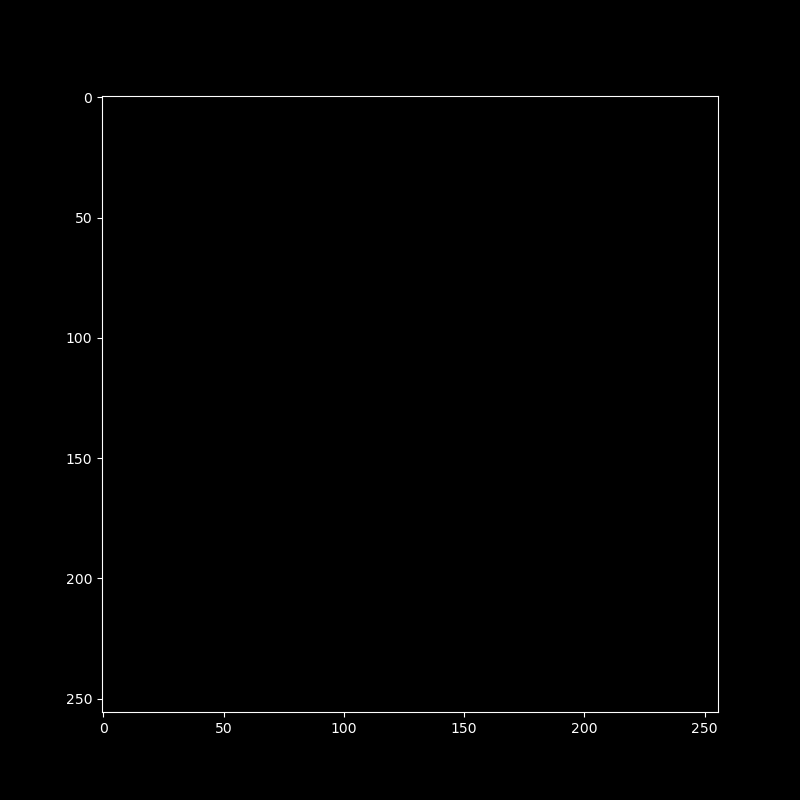

In [12]:
from skimage.color import rgb2gray
import numpy as np

from skimage import registration as skr
from skimage import transform as skt

gray_stack = np.zeros((astack.shape[0], astack.shape[1], astack.shape[2]))

for i in range(astack.shape[0]):
    gray_stack[i] = rgb2gray(astack[i])


junkie(gray_stack, figsize=(8, 8))


### 3. Registration
In **registration** we use the transformation to align consecutive slices. Here, we will use the **optical flow** to estimate the change in the signal across consecutive slices. We will use *optical_flow_tvl1* in the **skimage.registration** module to calculate the optical flow, and the *warp* function in **skimage.transform** to apply the optical flow field to consecutive slices.

First, take a look at the help for both functions and identify their key parameters:

In [14]:
# DELETE THIS CODE
from skimage import registration as skr

#skr.optical_flow_tvl1?

In [45]:
# DELETE THIS CODE
from skimage import transform as skt

#skt.warp?

In [19]:
import numpy as np
from skimage import registration as skr
from skimage import transform as skt
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity


gray_stack = np.zeros((astack.shape[0], astack.shape[1], astack.shape[2]), dtype=np.float32)

for i in range(astack.shape[0]):
    gray = rgb2gray(astack[i])
    gray_stack[i] = rescale_intensity(gray, out_range=(0, 1))


registered_stack = np.empty_like(gray_stack)
registered_stack[0] = gray_stack[0]


row_coords, col_coords = np.meshgrid(
    np.arange(gray_stack.shape[1]),
    np.arange(gray_stack.shape[2]),
    indexing='ij'
)


for slice_index in range(gray_stack.shape[0] - 1):
    flow = skr.optical_flow_tvl1(
        gray_stack[slice_index], gray_stack[slice_index + 1]
    )
    v = flow[0]
    u = flow[1]

  
    if np.isnan(flow).any():
        print(f"⚠️ Warning: NaN in flow at slice {slice_index}")

    registered_stack[slice_index + 1] = skt.warp(
        gray_stack[slice_index + 1],
        np.array([row_coords + v, col_coords + u]),
        order=5,
        mode='constant',
        cval=0,
        preserve_range=True
    )


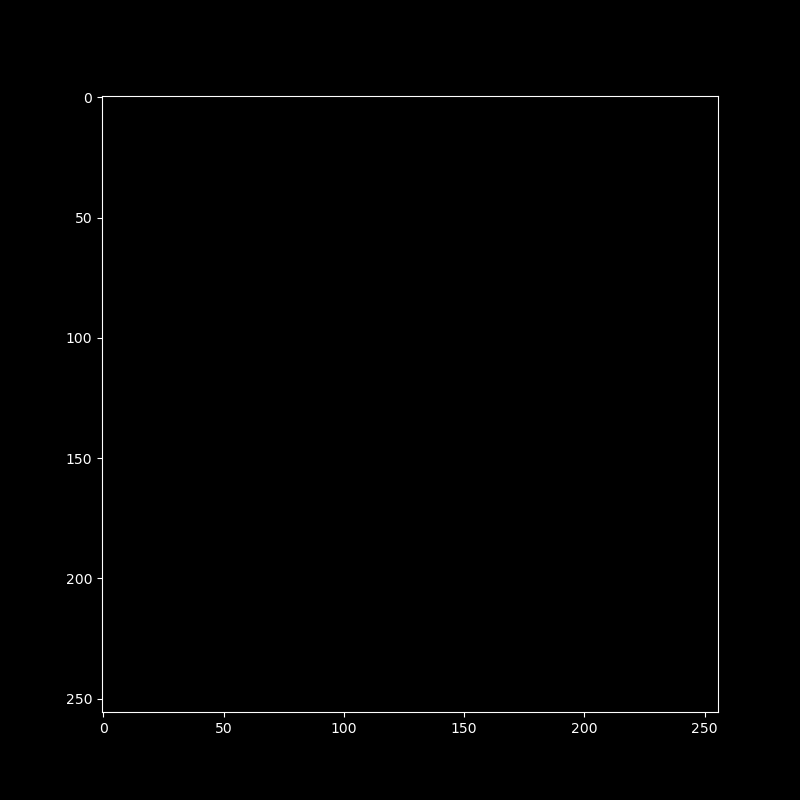

In [21]:
# DELETE THIS CODE
junkie(registered_stack, figsize=(8,8));

# order determines the type of interpolation applied: the greater the order, 
# the better the results (compare to order 0, nearest neighbour);
# mode defines what values are used for padding 
# (e.g. 'edges' repeats the values around the image edge)


In [47]:
# DELETE THIS CODE
#skr.optical_flow_ilk?

In [28]:
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
FIGSIZE = (8, 8)  

gray_stack = np.zeros((astack.shape[0], astack.shape[1], astack.shape[2]))
for i in range(astack.shape[0]):
    gray_stack[i] = rgb2gray(astack[i])


# configuration for quiver plots
nvec = 20  # number of vectors to be displayed along each image dimension
nr, nc = gray_stack.shape[1:] 
step = max(nr // nvec, nc // nvec)
figdims = (int(plt.rcParams['figure.dpi'] * FIGSIZE[0]), int(plt.rcParams['figure.dpi'] * FIGSIZE[1]))
flow_stack = np.empty((gray_stack.shape[0]-1, figdims[1], figdims[0])) 

# compute the optical flow: for every slice in the stack
for slice_index in range(gray_stack.shape[0]-1): 
    # compute the optical flow between the current and the next slice.
    v, u = skr.optical_flow_ilk(gray_stack[slice_index], gray_stack[slice_index+1], radius=7)

    # display optical flow
    flow_magnitude = np.sqrt(u ** 2 + v ** 2)

    y, x = np.mgrid[:nr:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    # create a figure and display the vector field overlaid on an image.
    fig = plt.figure(figsize=FIGSIZE, frameon=False, tight_layout=True)
    plt.imshow(gray_stack[slice_index], cmap='gray')  
    plt.quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale=0.25, scale_units='xy', lw=3)
    plt.gca().set_axis_off()

    # capture figure contents into flow_stack
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    rgba = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    flow_stack[slice_index] = rgba[:, :, 1]  

    plt.close(fig)



Use **junkie** to visualize *flow_stack*. What happens if you use different values for the *radius* parameter? 

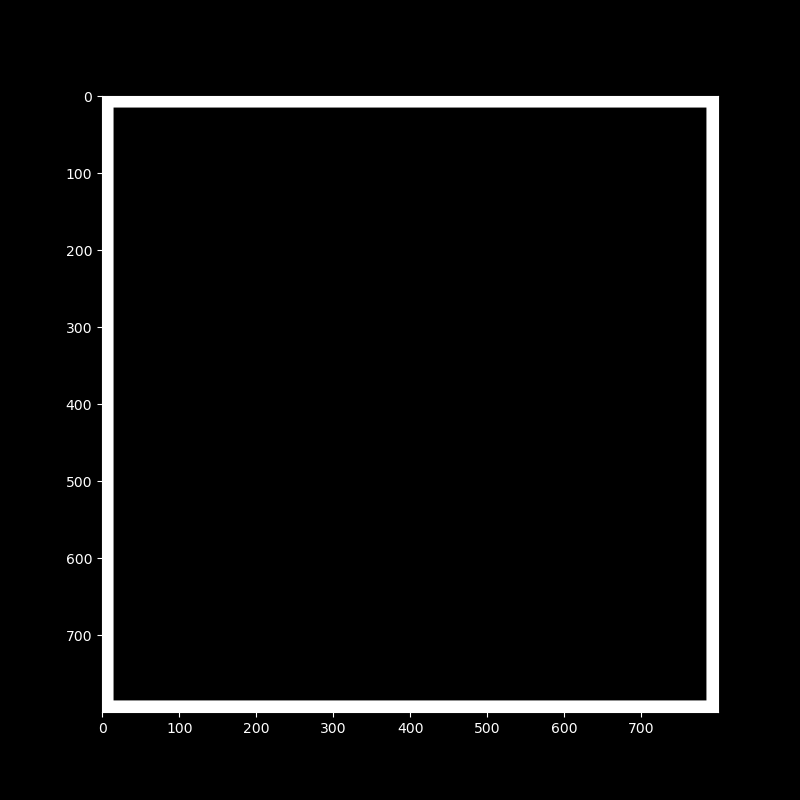

In [30]:
# DELETE THIS CODE
junkie(flow_stack, figsize=(8, 8));

# radius values that are too small (e.g. 3) lead to  disorganized vector fields;
# radius values that are too large (e.g. 128) lead to a uniform vector field;

In [49]:
import matplotlib.pyplot as plt
import os

save_dir = 'flow_stack_images'
os.makedirs(save_dir, exist_ok=True)

for i in range(flow_stack.shape[0]):
    fig, ax = plt.subplots()
    ax.imshow(flow_stack[i], cmap='gray') 
    ax.axis('off')
    fig.savefig(f"{save_dir}/slice_{i:03d}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)

print("saved")


saved


In [41]:
import shutil
shutil.make_archive("flow_stack_images", 'zip', "flow_stack_images")


'/Users/shimincheng/BME1462/flow_stack_images.zip'